# 📊 DBSCAN Twitter Clustering - Complete Parameter Tuning Analysis

**Objective:** Find optimal DBSCAN parameters for clustering Twitter data based on timestamp, latitude, and longitude using Euclidean distance.

**Dataset:** Twitter geo-tagged posts with timezone ground truth labels

**Navigation:**
- [Part 1: Data Exploration](#part-1-data-exploration)
- [Part 2: Parameter Tuning](#part-2-parameter-tuning--selection)
- [Part 3: Final Model](#part-3-final-model-application)

---

In [1]:
import pandas as pd
twitter = pd.read_csv('twitter.csv')
print(twitter.head())

   longitude   latitude       timestamp  timezone
0 -87.895450  43.063007  20130112000000         2
1 -93.674799  45.025114  20130112000000         2
2 -97.104568  32.709685  20130112000000         2
3 -71.120095  42.351453  20130112000000         1
4 -79.048690  43.100826  20130112000000         1


## Part 1: Data Exploration

Load and examine the Twitter dataset

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Apply min-max scaling to twitter['timestamp'] column
scaler_timestamp = MinMaxScaler()
twitter['timestamp_scaled'] = scaler_timestamp.fit_transform(twitter[['timestamp']])

# Apply min-max scaling to latitude and longitude
scaler_latlong = MinMaxScaler()
twitter[['lat_scaled', 'long_scaled']] = scaler_latlong.fit_transform(twitter[['latitude', 'longitude']])

print(f"Scaled Features Summary:")
print(f"  Timestamp range: [{twitter['timestamp_scaled'].min()}, {twitter['timestamp_scaled'].max()}]")
print(f"  Latitude range: [{twitter['lat_scaled'].min():.4f}, {twitter['lat_scaled'].max():.4f}]")
print(f"  Longitude range: [{twitter['long_scaled'].min():.4f}, {twitter['long_scaled'].max():.4f}]")

Scaled Features Summary:
  Timestamp range: [0.0, 1.0]
  Latitude range: [0.0000, 1.0000]
  Longitude range: [0.0000, 1.0000]


In [3]:
# Explore dataset structure and ground truth distribution
print(f"Dataset shape: {twitter.shape}")
print(f"\nColumns: {twitter.columns.tolist()}")
print(f"\nDataset info:")
print(twitter.info())

# Ground truth timezone distribution
print(f"\n📊 Timezone Distribution:")
print(f"   Total tweets: {len(twitter)}")
print(f"   Unique timezones: {twitter['timezone'].nunique()}")
print(f"\nTop 10 timezones:")
timezone_counts = twitter['timezone'].value_counts()
for i, (tz, count) in enumerate(timezone_counts.head(10).items(), 1):
    pct = (count / len(twitter)) * 100
    print(f"   {i}. {tz}: {count} ({pct:.1f}%)")

Dataset shape: (14262517, 7)

Columns: ['longitude', 'latitude', 'timestamp', 'timezone', 'timestamp_scaled', 'lat_scaled', 'long_scaled']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14262517 entries, 0 to 14262516
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   longitude         float64
 1   latitude          float64
 2   timestamp         int64  
 3   timezone          int64  
 4   timestamp_scaled  float64
 5   lat_scaled        float64
 6   long_scaled       float64
dtypes: float64(5), int64(2)
memory usage: 761.7 MB
None

📊 Timezone Distribution:
   Total tweets: 14262517
   Unique timezones: 4

Top 10 timezones:
   1. 1: 7404613 (51.9%)
   2. 2: 4382578 (30.7%)
   3. 4: 2094968 (14.7%)
   4. 3: 380358 (2.7%)


---

## Part 2: Parameter Tuning & Selection

Finding the optimal epsilon and min_samples parameters for DBSCAN on Twitter data

### Step 1: Sample 50k Points for Parameter Tuning

We'll use 50k samples for efficient parameter exploration

In [4]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, homogeneity_completeness_v_measure

# Sample 50k points for parameter tuning
TUNING_SAMPLE_SIZE = 50000
print(f"Original dataset size: {len(twitter)}")
print(f"Sampling {TUNING_SAMPLE_SIZE} points for parameter tuning...")

twitter_tuning_sample = twitter.sample(n=min(TUNING_SAMPLE_SIZE, len(twitter)), random_state=42)
twitter_tuning_idx = twitter_tuning_sample.index

# Prepare features for clustering
twitter_features_scaled = twitter[['timestamp_scaled', 'lat_scaled', 'long_scaled']]
twitter_tuning_features = twitter_features_scaled.loc[twitter_tuning_idx]

print(f"✅ Tuning sample prepared: {len(twitter_tuning_features)} samples")
print(f"   Features: timestamp_scaled, lat_scaled, long_scaled")
print(f"   Metric: Euclidean (L2) distance")

Original dataset size: 14262517
Sampling 50000 points for parameter tuning...
✅ Tuning sample prepared: 50000 samples
   Features: timestamp_scaled, lat_scaled, long_scaled
   Metric: Euclidean (L2) distance
✅ Tuning sample prepared: 50000 samples
   Features: timestamp_scaled, lat_scaled, long_scaled
   Metric: Euclidean (L2) distance


### Step 2: K-Distance Plot (Initial Exploration)

The k-distance plot helps us choose an appropriate epsilon value for DBSCAN

In [5]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Choose k = min_samples (starting with k=20 as in original code)
k = 20

# Fit NearestNeighbors to find k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=k, metric='euclidean')
neighbors.fit(twitter_tuning_features)

# Get distances to k-th nearest neighbor for each point
distances, indices = neighbors.kneighbors(twitter_tuning_features)

# Sort the distances in ascending order (take last column = k-th neighbor)
k_distances = np.sort(distances[:, -1])

print(f"Computing {k}-distance plot for {len(k_distances)} samples...")
print(f"Distance range: [{k_distances.min():.4f}, {k_distances.max():.4f}]")
print(f"Median distance: {np.median(k_distances):.4f}")
print(f"75th percentile: {np.percentile(k_distances, 75):.4f}")
print(f"90th percentile: {np.percentile(k_distances, 90):.4f}")
print(f"95th percentile: {np.percentile(k_distances, 95):.4f}")

Computing 20-distance plot for 50000 samples...
Distance range: [0.0028, 0.1763]
Median distance: 0.0136
75th percentile: 0.0216
90th percentile: 0.0307
95th percentile: 0.0389


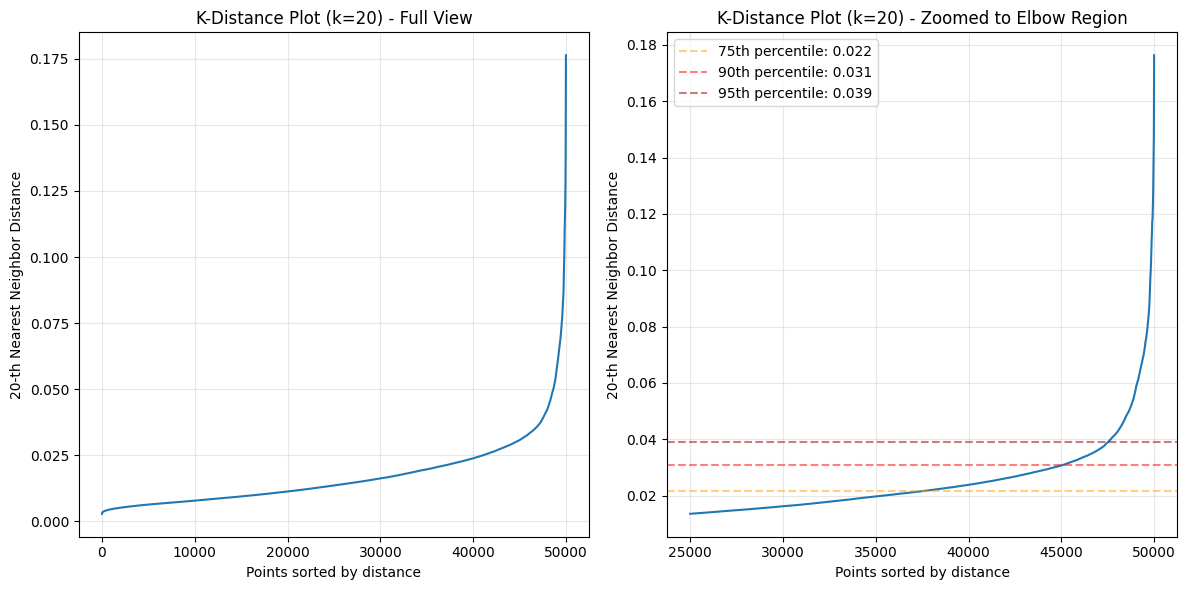


🎯 How to choose epsilon:
   1. Look for the 'elbow' point where the curve sharply increases
   2. The y-value at that point is a good epsilon candidate
   3. Points to the left of the elbow will be in clusters
   4. Points to the right will likely be noise


In [6]:
# Plot the k-distance graph
plt.figure(figsize=(12, 6))

# Full plot
plt.subplot(1, 2, 1)
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title(f'K-Distance Plot (k={k}) - Full View')
plt.grid(True, alpha=0.3)

# Zoomed plot focusing on the elbow region
plt.subplot(1, 2, 2)
focus_start = int(len(k_distances) * 0.5)  # Start from 50% of points
plt.plot(range(focus_start, len(k_distances)), k_distances[focus_start:])
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title(f'K-Distance Plot (k={k}) - Zoomed to Elbow Region')
plt.grid(True, alpha=0.3)

# Add reference lines for common percentiles
for percentile, color in [(75, 'orange'), (90, 'red'), (95, 'darkred')]:
    value = np.percentile(k_distances, percentile)
    plt.axhline(y=value, color=color, linestyle='--', alpha=0.5, 
                label=f'{percentile}th percentile: {value:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

print("\n🎯 How to choose epsilon:")
print("   1. Look for the 'elbow' point where the curve sharply increases")
print("   2. The y-value at that point is a good epsilon candidate")
print("   3. Points to the left of the elbow will be in clusters")
print("   4. Points to the right will likely be noise")

### Step 3: K-Distance Plots with Varying min_samples

Generate k-distance plots for different min_samples values

Computing k-distance for min_samples=5...
  min_samples=5: median=0.0061, 90th=0.0163, 95th=0.0209
Computing k-distance for min_samples=10...
  min_samples=5: median=0.0061, 90th=0.0163, 95th=0.0209
Computing k-distance for min_samples=10...
  min_samples=10: median=0.0092, 90th=0.0226, 95th=0.0285
Computing k-distance for min_samples=15...
  min_samples=10: median=0.0092, 90th=0.0226, 95th=0.0285
Computing k-distance for min_samples=15...
  min_samples=15: median=0.0116, 90th=0.0271, 95th=0.0338
Computing k-distance for min_samples=20...
  min_samples=15: median=0.0116, 90th=0.0271, 95th=0.0338
Computing k-distance for min_samples=20...
  min_samples=20: median=0.0136, 90th=0.0307, 95th=0.0389
Computing k-distance for min_samples=30...
  min_samples=20: median=0.0136, 90th=0.0307, 95th=0.0389
Computing k-distance for min_samples=30...
  min_samples=30: median=0.0168, 90th=0.0369, 95th=0.0477
  min_samples=30: median=0.0168, 90th=0.0369, 95th=0.0477


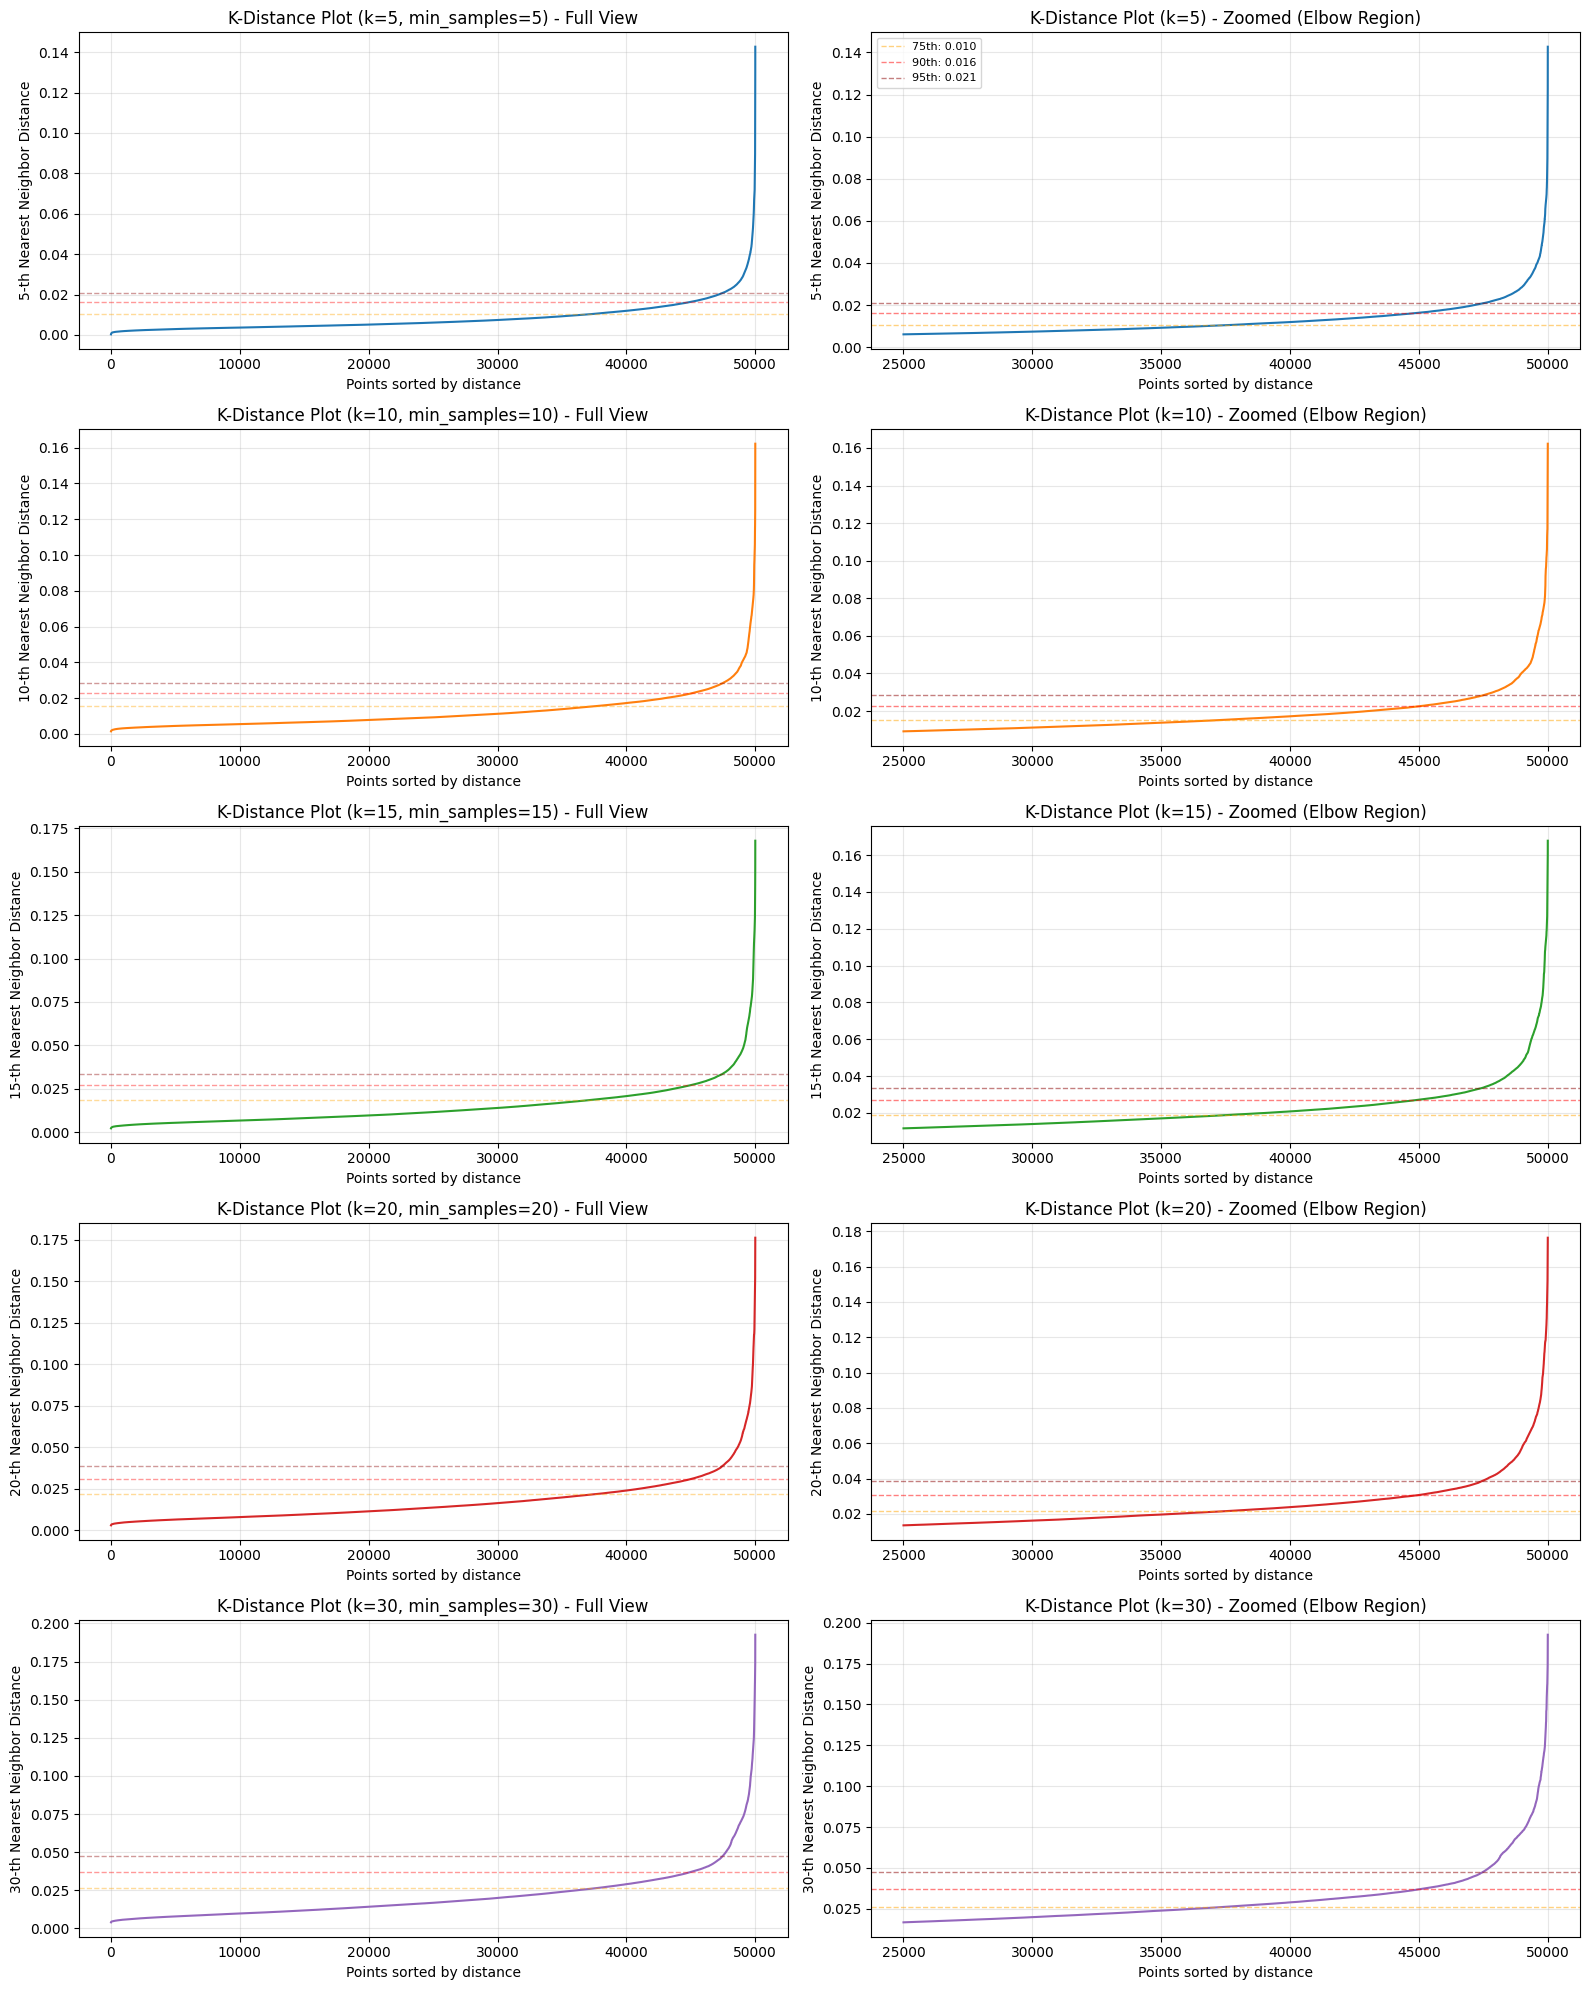


💡 Analysis:
   • Smaller min_samples (e.g., 5-10) more sensitive to local density
   • Larger min_samples (e.g., 20-30) focus on substantial dense regions
   • Look for elbow point in zoomed plots to choose epsilon


In [7]:
# Test different min_samples values
min_samples_values = [5, 10, 15, 20, 30]

# Create subplots - 2 columns for each min_samples (full view and zoomed)
fig, axes = plt.subplots(len(min_samples_values), 2, figsize=(16, 4 * len(min_samples_values)))

for idx, k in enumerate(min_samples_values):
    print(f"Computing k-distance for min_samples={k}...")
    
    # Compute k-nearest neighbors
    neighbors = NearestNeighbors(n_neighbors=k, metric='euclidean')
    neighbors.fit(twitter_tuning_features)
    distances, indices = neighbors.kneighbors(twitter_tuning_features)
    
    # Get the distance to the k-th nearest neighbor (last column)
    k_distances = distances[:, -1]
    k_distances = np.sort(k_distances)
    
    # Plot full view
    ax_full = axes[idx, 0]
    ax_full.plot(k_distances, linewidth=1.5, color=f'C{idx}')
    ax_full.set_xlabel('Points sorted by distance')
    ax_full.set_ylabel(f'{k}-th Nearest Neighbor Distance')
    ax_full.set_title(f'K-Distance Plot (k={k}, min_samples={k}) - Full View')
    ax_full.grid(True, alpha=0.3)
    
    # Add percentile lines
    for percentile, color in [(75, 'orange'), (90, 'red'), (95, 'darkred')]:
        value = np.percentile(k_distances, percentile)
        ax_full.axhline(y=value, color=color, linestyle='--', alpha=0.4, linewidth=1)
    
    # Plot zoomed view (focusing on elbow region)
    ax_zoom = axes[idx, 1]
    focus_start = int(len(k_distances) * 0.5)
    ax_zoom.plot(range(focus_start, len(k_distances)), k_distances[focus_start:], 
                 linewidth=1.5, color=f'C{idx}')
    ax_zoom.set_xlabel('Points sorted by distance')
    ax_zoom.set_ylabel(f'{k}-th Nearest Neighbor Distance')
    ax_zoom.set_title(f'K-Distance Plot (k={k}) - Zoomed (Elbow Region)')
    ax_zoom.grid(True, alpha=0.3)
    
    # Add percentile lines with labels
    for percentile, color in [(75, 'orange'), (90, 'red'), (95, 'darkred')]:
        value = np.percentile(k_distances, percentile)
        label = f'{percentile}th: {value:.3f}' if idx == 0 else None
        ax_zoom.axhline(y=value, color=color, linestyle='--', alpha=0.5, linewidth=1, label=label)
    
    if idx == 0:
        ax_zoom.legend(loc='upper left', fontsize=8)
    
    # Print statistics
    print(f"  min_samples={k}: median={np.median(k_distances):.4f}, "
          f"90th={np.percentile(k_distances, 90):.4f}, "
          f"95th={np.percentile(k_distances, 95):.4f}")

plt.tight_layout()
plt.show()

print("\n💡 Analysis:")
print("   • Smaller min_samples (e.g., 5-10) more sensitive to local density")
print("   • Larger min_samples (e.g., 20-30) focus on substantial dense regions")
print("   • Look for elbow point in zoomed plots to choose epsilon")

### Step 4: Comprehensive Grid Search

Systematically test different combinations of eps and min_samples

In [8]:
# Grid search over multiple parameter combinations
min_samples_range = [5, 10, 15, 20, 30]
# Epsilon values based on Euclidean distance in scaled [0,1] space
eps_range = {
    5: [0.05, 0.08, 0.10, 0.12, 0.15],
    10: [0.08, 0.10, 0.12, 0.15, 0.18],
    15: [0.10, 0.12, 0.15, 0.18, 0.20],
    20: [0.12, 0.15, 0.18, 0.20, 0.25],
    30: [0.15, 0.18, 0.20, 0.25, 0.30]
}

all_results = []

print("🔍 Testing parameter combinations on 50k sample...\n")
print("=" * 120)

for min_samp in min_samples_range:
    print(f"\n📊 Testing min_samples = {min_samp}")
    print("-" * 120)
    
    for eps in eps_range[min_samp]:
        # Run DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samp, metric='euclidean', n_jobs=-1)
        clusters = dbscan.fit_predict(twitter_tuning_features)
        
        # Calculate metrics
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)
        noise_pct = (n_noise / len(clusters)) * 100
        
        # External metrics (comparing to ground truth timezones)
        actual_timezones = twitter.loc[twitter_tuning_idx, 'timezone']
        ari = adjusted_rand_score(actual_timezones, clusters)
        nmi = normalized_mutual_info_score(actual_timezones, clusters)
        
        # Silhouette score (internal metric)
        non_noise_mask = clusters != -1
        if n_clusters > 1 and non_noise_mask.sum() > 1:
            try:
                silhouette = silhouette_score(
                    twitter_tuning_features[non_noise_mask], 
                    clusters[non_noise_mask], 
                    metric='euclidean'
                )
            except:
                silhouette = None
        else:
            silhouette = None
        
        all_results.append({
            'min_samples': min_samp,
            'epsilon': eps,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': noise_pct,
            'ARI': ari,
            'NMI': nmi,
            'silhouette': silhouette
        })
        
        # Print with indicators for good results
        ari_symbol = "⭐" if ari > 0.3 else "✓" if ari > 0.1 else " "
        print(f"  eps={eps:.2f} | Clusters: {n_clusters:3d} | Noise: {noise_pct:5.1f}% | "
              f"ARI: {ari:6.4f} {ari_symbol} | NMI: {nmi:6.4f} | "
              f"Silhouette: {silhouette if silhouette else 'N/A':>6}")

print("\n" + "=" * 120)

🔍 Testing parameter combinations on 50k sample...


📊 Testing min_samples = 5
------------------------------------------------------------------------------------------------------------------------
  eps=0.05 | Clusters:  49 | Noise:   0.2% | ARI: 0.0327   | NMI: 0.1320 | Silhouette: -0.07748084138833944
  eps=0.05 | Clusters:  49 | Noise:   0.2% | ARI: 0.0327   | NMI: 0.1320 | Silhouette: -0.07748084138833944
  eps=0.08 | Clusters:   8 | Noise:   0.0% | ARI: 0.0002   | NMI: 0.0009 | Silhouette: 0.07398418683977041
  eps=0.08 | Clusters:   8 | Noise:   0.0% | ARI: 0.0002   | NMI: 0.0009 | Silhouette: 0.07398418683977041
  eps=0.10 | Clusters:   7 | Noise:   0.0% | ARI: 0.0001   | NMI: 0.0003 | Silhouette: 0.09786842494893298
  eps=0.10 | Clusters:   7 | Noise:   0.0% | ARI: 0.0001   | NMI: 0.0003 | Silhouette: 0.09786842494893298
  eps=0.12 | Clusters:   7 | Noise:   0.0% | ARI: 0.0001   | NMI: 0.0001 | Silhouette: 0.0978563409092343
  eps=0.12 | Clusters:   7 | Noise:   0.0% | ARI: 0

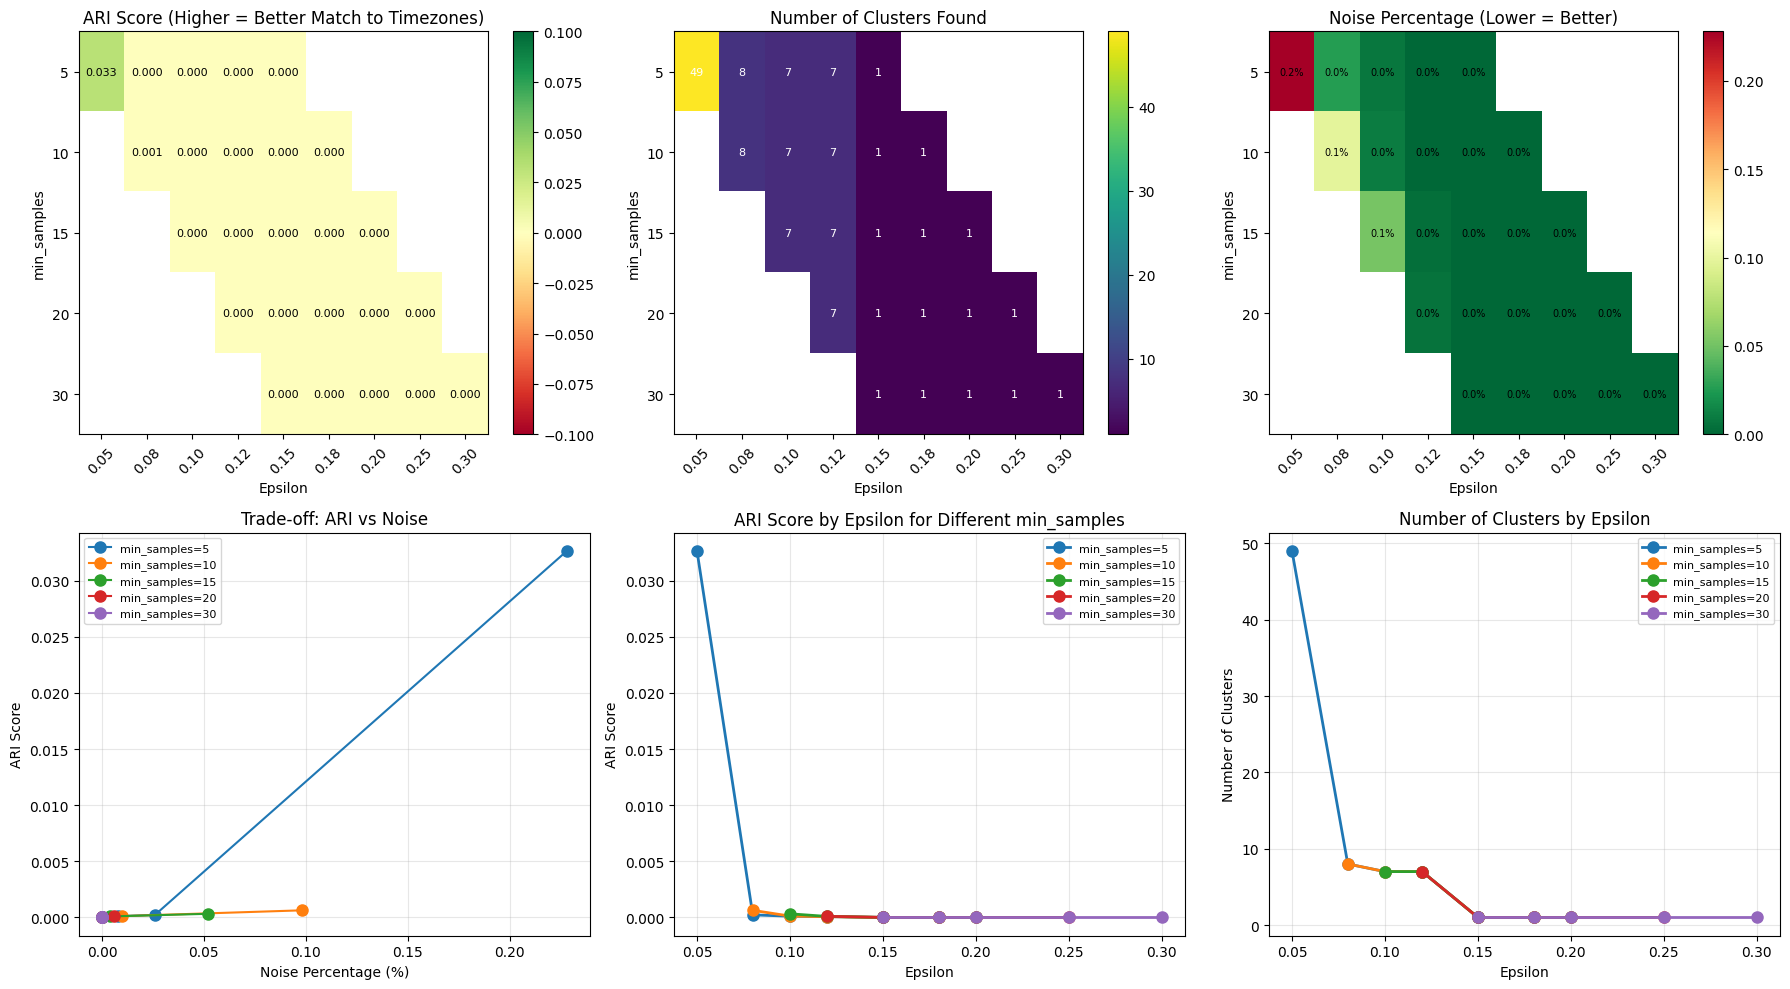

In [9]:
# Create comprehensive visualization
all_results_df = pd.DataFrame(all_results)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: ARI heatmap
pivot_ari = all_results_df.pivot(index='min_samples', columns='epsilon', values='ARI')
ax1 = axes[0, 0]
im1 = ax1.imshow(pivot_ari.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=pivot_ari.values.max())
ax1.set_xticks(range(len(pivot_ari.columns)))
ax1.set_yticks(range(len(pivot_ari.index)))
ax1.set_xticklabels([f'{x:.2f}' for x in pivot_ari.columns], rotation=45)
ax1.set_yticklabels(pivot_ari.index)
ax1.set_xlabel('Epsilon')
ax1.set_ylabel('min_samples')
ax1.set_title('ARI Score (Higher = Better Match to Timezones)')
plt.colorbar(im1, ax=ax1)

# Add text annotations
for i in range(len(pivot_ari.index)):
    for j in range(len(pivot_ari.columns)):
        if not np.isnan(pivot_ari.values[i, j]):
            text = ax1.text(j, i, f'{pivot_ari.values[i, j]:.3f}',
                           ha="center", va="center", color="black", fontsize=8)

# Plot 2: Number of clusters heatmap
pivot_clusters = all_results_df.pivot(index='min_samples', columns='epsilon', values='n_clusters')
ax2 = axes[0, 1]
im2 = ax2.imshow(pivot_clusters.values, cmap='viridis', aspect='auto')
ax2.set_xticks(range(len(pivot_clusters.columns)))
ax2.set_yticks(range(len(pivot_clusters.index)))
ax2.set_xticklabels([f'{x:.2f}' for x in pivot_clusters.columns], rotation=45)
ax2.set_yticklabels(pivot_clusters.index)
ax2.set_xlabel('Epsilon')
ax2.set_ylabel('min_samples')
ax2.set_title('Number of Clusters Found')
plt.colorbar(im2, ax=ax2)

# Add text annotations
for i in range(len(pivot_clusters.index)):
    for j in range(len(pivot_clusters.columns)):
        if not np.isnan(pivot_clusters.values[i, j]):
            text = ax2.text(j, i, f'{int(pivot_clusters.values[i, j])}',
                           ha="center", va="center", color="white", fontsize=8)

# Plot 3: Noise percentage heatmap
pivot_noise = all_results_df.pivot(index='min_samples', columns='epsilon', values='noise_pct')
ax3 = axes[0, 2]
im3 = ax3.imshow(pivot_noise.values, cmap='RdYlGn_r', aspect='auto')
ax3.set_xticks(range(len(pivot_noise.columns)))
ax3.set_yticks(range(len(pivot_noise.index)))
ax3.set_xticklabels([f'{x:.2f}' for x in pivot_noise.columns], rotation=45)
ax3.set_yticklabels(pivot_noise.index)
ax3.set_xlabel('Epsilon')
ax3.set_ylabel('min_samples')
ax3.set_title('Noise Percentage (Lower = Better)')
plt.colorbar(im3, ax=ax3)

# Add text annotations
for i in range(len(pivot_noise.index)):
    for j in range(len(pivot_noise.columns)):
        if not np.isnan(pivot_noise.values[i, j]):
            text = ax3.text(j, i, f'{pivot_noise.values[i, j]:.1f}%',
                           ha="center", va="center", color="black", fontsize=7)

# Plot 4: ARI vs Noise percentage
ax4 = axes[1, 0]
for min_samp in min_samples_range:
    subset = all_results_df[all_results_df['min_samples'] == min_samp]
    ax4.plot(subset['noise_pct'], subset['ARI'], 'o-', label=f'min_samples={min_samp}', markersize=8)
ax4.set_xlabel('Noise Percentage (%)')
ax4.set_ylabel('ARI Score')
ax4.set_title('Trade-off: ARI vs Noise')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# Plot 5: ARI by epsilon
ax5 = axes[1, 1]
for min_samp in min_samples_range:
    subset = all_results_df[all_results_df['min_samples'] == min_samp]
    ax5.plot(subset['epsilon'], subset['ARI'], 'o-', label=f'min_samples={min_samp}', markersize=8, linewidth=2)
ax5.set_xlabel('Epsilon')
ax5.set_ylabel('ARI Score')
ax5.set_title('ARI Score by Epsilon for Different min_samples')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# Plot 6: Number of clusters by epsilon
ax6 = axes[1, 2]
for min_samp in min_samples_range:
    subset = all_results_df[all_results_df['min_samples'] == min_samp]
    ax6.plot(subset['epsilon'], subset['n_clusters'], 'o-', label=f'min_samples={min_samp}', markersize=8, linewidth=2)
ax6.set_xlabel('Epsilon')
ax6.set_ylabel('Number of Clusters')
ax6.set_title('Number of Clusters by Epsilon')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Find and recommend the best parameters
print("\n" + "🎯" * 40)
print("\n📋 PARAMETER RECOMMENDATIONS FOR TWITTER DATASET\n")
print("=" * 120)

# Top 5 by ARI
top_ari = all_results_df.nlargest(5, 'ARI')
print("\n🏆 TOP 5 CONFIGURATIONS BY ARI (Match to Ground Truth Timezones):")
print("-" * 120)
for i, row in enumerate(top_ari.iterrows(), 1):
    r = row[1]
    print(f"{i}. min_samples={int(r['min_samples']):2d}, eps={r['epsilon']:.2f} → "
          f"ARI={r['ARI']:.4f}, Clusters={int(r['n_clusters']):3d}, Noise={r['noise_pct']:5.1f}%, "
          f"NMI={r['NMI']:.4f}")

# Best balance (high ARI, reasonable noise)
balanced = all_results_df[(all_results_df['noise_pct'] < 50) & (all_results_df['n_clusters'] >= 3)]
if len(balanced) > 0:
    balanced_top = balanced.nlargest(3, 'ARI')
    print("\n⚖️  TOP 3 BALANCED CONFIGURATIONS (Good ARI + Low Noise < 50%):")
    print("-" * 120)
    for i, row in enumerate(balanced_top.iterrows(), 1):
        r = row[1]
        print(f"{i}. min_samples={int(r['min_samples']):2d}, eps={r['epsilon']:.2f} → "
              f"ARI={r['ARI']:.4f}, Clusters={int(r['n_clusters']):3d}, Noise={r['noise_pct']:5.1f}%, "
              f"NMI={r['NMI']:.4f}")

# Best by different criteria
best_ari = all_results_df.loc[all_results_df['ARI'].idxmax()]
best_nmi = all_results_df.loc[all_results_df['NMI'].idxmax()]
best_silhouette = all_results_df[all_results_df['silhouette'].notna()]
if len(best_silhouette) > 0:
    best_silhouette = best_silhouette.loc[best_silhouette['silhouette'].idxmax()]

print("\n✨ BEST BY SPECIFIC CRITERIA:")
print("-" * 120)
print(f"🥇 Best ARI: min_samples={int(best_ari['min_samples'])}, eps={best_ari['epsilon']:.2f} "
      f"(ARI={best_ari['ARI']:.4f}, {int(best_ari['n_clusters'])} clusters, {best_ari['noise_pct']:.1f}% noise)")
print(f"🥈 Best NMI: min_samples={int(best_nmi['min_samples'])}, eps={best_nmi['epsilon']:.2f} "
      f"(NMI={best_nmi['NMI']:.4f}, {int(best_nmi['n_clusters'])} clusters, {best_nmi['noise_pct']:.1f}% noise)")
if len(all_results_df[all_results_df['silhouette'].notna()]) > 0:
    print(f"🥉 Best Silhouette: min_samples={int(best_silhouette['min_samples'])}, eps={best_silhouette['epsilon']:.2f} "
          f"(Silhouette={best_silhouette['silhouette']:.4f}, {int(best_silhouette['n_clusters'])} clusters, {best_silhouette['noise_pct']:.1f}% noise)")

print("\n💡 INTERPRETATION GUIDE:")
print("-" * 120)
print("• ARI (Adjusted Rand Index): Measures similarity to ground truth timezones (0=random, 1=perfect)")
print("• NMI (Normalized Mutual Info): Measures shared information with ground truth (0=independent, 1=identical)")
print("• Silhouette Score: Internal cluster quality (-1=wrong cluster, 0=boundary, 1=well-clustered)")
print("• Noise %: Percentage of points labeled as outliers")

print("\n🎯 WHAT TO CHOOSE:")
print("• For maximum accuracy vs ground truth → Use the top ARI configuration")
print("• For practical clustering with low noise → Use a balanced configuration")
print("• Consider domain: Twitter geo-spatial clustering may have natural outliers")
print("\n" + "=" * 120)


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

📋 PARAMETER RECOMMENDATIONS FOR TWITTER DATASET


🏆 TOP 5 CONFIGURATIONS BY ARI (Match to Ground Truth Timezones):
------------------------------------------------------------------------------------------------------------------------
1. min_samples= 5, eps=0.05 → ARI=0.0327, Clusters= 49, Noise=  0.2%, NMI=0.1320
2. min_samples=10, eps=0.08 → ARI=0.0006, Clusters=  8, Noise=  0.1%, NMI=0.0028
3. min_samples=15, eps=0.10 → ARI=0.0003, Clusters=  7, Noise=  0.1%, NMI=0.0014
4. min_samples= 5, eps=0.08 → ARI=0.0002, Clusters=  8, Noise=  0.0%, NMI=0.0009
5. min_samples=10, eps=0.10 → ARI=0.0001, Clusters=  7, Noise=  0.0%, NMI=0.0004

⚖️  TOP 3 BALANCED CONFIGURATIONS (Good ARI + Low Noise < 50%):
------------------------------------------------------------------------------------------------------------------------
1. min_samples= 5, eps=0.05 → ARI=0.0327, Clusters= 49, Noise=  0.2%, NMI=0.1320
2. min_samples=10, eps=0.08 → ARI=0.0006, Cluster

---

## Part 3: Final Model Application

### Apply Recommended Parameters

In [11]:
# Apply the best parameter combination on 50k sample
RECOMMENDED_MIN_SAMPLES = int(best_ari['min_samples'])
RECOMMENDED_EPS = best_ari['epsilon']

print("🎯 Applying recommended parameters on 50k sample:")
print(f"   min_samples = {RECOMMENDED_MIN_SAMPLES}")
print(f"   epsilon = {RECOMMENDED_EPS}")
print(f"   metric = euclidean (L2)\n")

# Run DBSCAN with recommended parameters
final_dbscan = DBSCAN(eps=RECOMMENDED_EPS, min_samples=RECOMMENDED_MIN_SAMPLES, metric='euclidean', n_jobs=-1)
final_clusters = final_dbscan.fit_predict(twitter_tuning_features)

# Detailed analysis
n_clusters = len(set(final_clusters)) - (1 if -1 in final_clusters else 0)
n_noise = list(final_clusters).count(-1)
noise_pct = (n_noise / len(final_clusters)) * 100

print("=" * 80)
print("CLUSTERING RESULTS (50k Sample):")
print("=" * 80)
print(f"📊 Number of clusters found: {n_clusters}")
print(f"🔊 Noise points: {n_noise} ({noise_pct:.1f}%)")
print(f"📦 Clustered points: {len(final_clusters) - n_noise} ({100-noise_pct:.1f}%)")

# Cluster size distribution
cluster_counts = pd.Series(final_clusters).value_counts().sort_index()
non_noise_counts = cluster_counts[cluster_counts.index != -1]
if len(non_noise_counts) > 0:
    print(f"\n📈 Cluster size distribution:")
    print(f"   Smallest cluster: {non_noise_counts.min()} points")
    print(f"   Largest cluster: {non_noise_counts.max()} points")
    print(f"   Average cluster size: {non_noise_counts.mean():.1f} points")
    print(f"   Median cluster size: {non_noise_counts.median():.1f} points")

# Compare to ground truth
actual_timezones = twitter.loc[twitter_tuning_idx, 'timezone']
ari = adjusted_rand_score(actual_timezones, final_clusters)
nmi = normalized_mutual_info_score(actual_timezones, final_clusters)
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(actual_timezones, final_clusters)

print(f"\n🎯 Comparison to Ground Truth Timezones:")
print(f"   ARI: {ari:.4f}")
print(f"   NMI: {nmi:.4f}")
print(f"   Homogeneity: {homogeneity:.4f}")
print(f"   Completeness: {completeness:.4f}")
print(f"   V-Measure: {v_measure:.4f}")

# Add clusters to dataframe for inspection
twitter_with_clusters = twitter.copy()
twitter_with_clusters['DBSCAN_Cluster'] = -1  # Initialize all as noise
twitter_with_clusters.loc[twitter_tuning_idx, 'DBSCAN_Cluster'] = final_clusters

print(f"\n✅ Results saved to 'twitter_with_clusters' dataframe")
print(f"   Compare: 'timezone' (ground truth) vs 'DBSCAN_Cluster' (our result)")
print("=" * 80)

🎯 Applying recommended parameters on 50k sample:
   min_samples = 5
   epsilon = 0.05
   metric = euclidean (L2)

CLUSTERING RESULTS (50k Sample):
📊 Number of clusters found: 49
🔊 Noise points: 114 (0.2%)
📦 Clustered points: 49886 (99.8%)

📈 Cluster size distribution:
   Smallest cluster: 5 points
   Largest cluster: 7473 points
   Average cluster size: 1018.1 points
   Median cluster size: 29.0 points

🎯 Comparison to Ground Truth Timezones:
   ARI: 0.0327
   NMI: 0.1320
   Homogeneity: 0.2045
   Completeness: 0.0974
   V-Measure: 0.1320

✅ Results saved to 'twitter_with_clusters' dataframe
   Compare: 'timezone' (ground truth) vs 'DBSCAN_Cluster' (our result)

✅ Results saved to 'twitter_with_clusters' dataframe
   Compare: 'timezone' (ground truth) vs 'DBSCAN_Cluster' (our result)


### Cluster Mapping Analysis

Analyze how DBSCAN clusters map to ground truth timezones

In [12]:
# Helper function to calculate purity
def calculate_purity(ground_truth, clusters):
    """
    Calculate cluster purity: for each cluster, find the most common class,
    then sum the counts of the most common class across all clusters.
    """
    from collections import Counter
    
    # Create a mapping of cluster -> ground truth labels
    cluster_to_labels = {}
    for cluster, label in zip(clusters, ground_truth):
        if cluster not in cluster_to_labels:
            cluster_to_labels[cluster] = []
        cluster_to_labels[cluster].append(label)
    
    # Calculate purity
    total_correct = 0
    for cluster, labels in cluster_to_labels.items():
        most_common_count = Counter(labels).most_common(1)[0][1]
        total_correct += most_common_count
    
    return total_correct / len(clusters)

# Analyze cluster mapping
twitter_sample_data = twitter_with_clusters.loc[twitter_tuning_idx]

print("Cluster Mapping: DBSCAN Cluster → Ground Truth Timezones")
print("=" * 80)

# Get unique DBSCAN clusters (excluding noise for main analysis)
unique_clusters = sorted([c for c in set(final_clusters) if c != -1])
display_limit = min(10, len(unique_clusters))  # Show top 10 clusters

for dbscan_cluster in unique_clusters[:display_limit]:
    # Get all samples in this DBSCAN cluster
    cluster_data = twitter_sample_data[twitter_sample_data['DBSCAN_Cluster'] == dbscan_cluster]
    
    # Count ground truth timezones in this cluster
    timezone_counts = cluster_data['timezone'].value_counts()
    total_in_cluster = len(cluster_data)
    
    print(f"\nDBSCAN Cluster {dbscan_cluster} ({total_in_cluster} samples):")
    print(f"  Top ground truth timezones:")
    for i, (timezone, count) in enumerate(timezone_counts.head(5).items(), 1):
        percentage = (count / total_in_cluster) * 100
        print(f"    {i}. '{timezone}': {count} ({percentage:.1f}%)")
    
    # Purity: percentage of most common timezone
    if len(timezone_counts) > 0:
        purity = (timezone_counts.iloc[0] / total_in_cluster) * 100
        print(f"  Purity: {purity:.1f}% (dominated by '{timezone_counts.index[0]}')")

# Overall cluster purity
purity_twitter = calculate_purity(actual_timezones, final_clusters)
print(f"\n{'=' * 80}")
print(f"Overall Cluster Purity: {purity_twitter:.4f}")
print(f"  (Higher is better, 1.0 means each cluster is pure)")

# Show noise cluster statistics
noise_count = (final_clusters == -1).sum()
if noise_count > 0:
    print(f"\nNoise Points (Cluster -1): {noise_count} samples ({noise_count/len(final_clusters)*100:.1f}%)")
    noise_data = twitter_sample_data[twitter_sample_data['DBSCAN_Cluster'] == -1]
    noise_timezones = noise_data['timezone'].value_counts()
    print(f"  Top timezones in noise:")
    for timezone, count in noise_timezones.head(5).items():
        print(f"    '{timezone}': {count}")

Cluster Mapping: DBSCAN Cluster → Ground Truth Timezones

DBSCAN Cluster 0 (6680 samples):
  Top ground truth timezones:
    1. '1': 3613 (54.1%)
    2. '2': 2113 (31.6%)
    3. '4': 933 (14.0%)
    4. '3': 21 (0.3%)
  Purity: 54.1% (dominated by '1')

DBSCAN Cluster 1 (898 samples):
  Top ground truth timezones:
    1. '4': 861 (95.9%)
    2. '3': 37 (4.1%)
  Purity: 95.9% (dominated by '4')

DBSCAN Cluster 2 (5981 samples):
  Top ground truth timezones:
    1. '1': 3753 (62.7%)
    2. '2': 2145 (35.9%)
    3. '3': 83 (1.4%)
  Purity: 62.7% (dominated by '1')

DBSCAN Cluster 3 (6813 samples):
  Top ground truth timezones:
    1. '1': 3802 (55.8%)
    2. '2': 2099 (30.8%)
    3. '4': 869 (12.8%)
    4. '3': 43 (0.6%)
  Purity: 55.8% (dominated by '1')

DBSCAN Cluster 4 (7473 samples):
  Top ground truth timezones:
    1. '1': 4100 (54.9%)
    2. '2': 2328 (31.2%)
    3. '4': 925 (12.4%)
    4. '3': 120 (1.6%)
  Purity: 54.9% (dominated by '1')

DBSCAN Cluster 5 (6773 samples):
  Top gr

### Visualize Clustering Results

Spatial visualization of clusters on a map

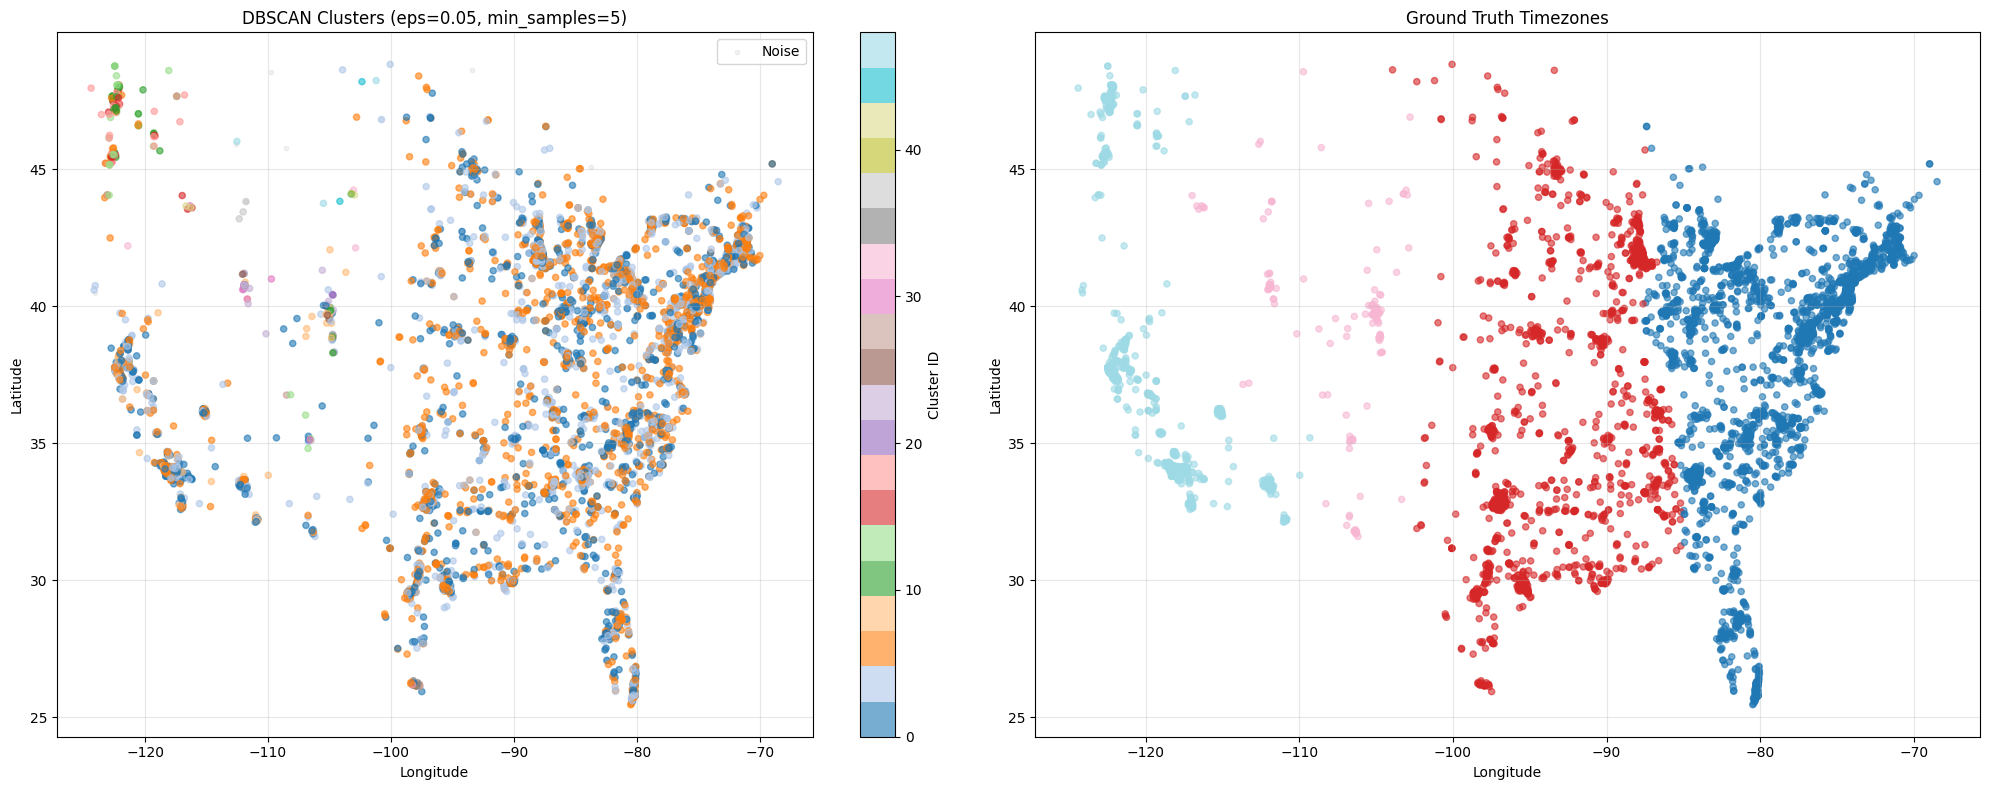


📍 Visualization showing 5000 sampled points
   Left: DBSCAN clustering results
   Right: Ground truth timezone labels


In [13]:
# Visualize clusters on a scatter plot (lat/long)
# Sample a subset for clearer visualization
viz_sample_size = 5000
viz_indices = np.random.choice(twitter_tuning_idx, min(viz_sample_size, len(twitter_tuning_idx)), replace=False)
viz_data = twitter_with_clusters.loc[viz_indices]

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: DBSCAN clusters
ax1 = axes[0]
# Separate noise from clusters
noise_mask = viz_data['DBSCAN_Cluster'] == -1
clustered_mask = ~noise_mask

# Plot noise points in gray
ax1.scatter(viz_data.loc[noise_mask, 'longitude'], 
           viz_data.loc[noise_mask, 'latitude'],
           c='lightgray', alpha=0.3, s=10, label='Noise')

# Plot clustered points with colors
if clustered_mask.sum() > 0:
    scatter1 = ax1.scatter(viz_data.loc[clustered_mask, 'longitude'], 
                          viz_data.loc[clustered_mask, 'latitude'],
                          c=viz_data.loc[clustered_mask, 'DBSCAN_Cluster'],
                          cmap='tab20', alpha=0.6, s=20)
    plt.colorbar(scatter1, ax=ax1, label='Cluster ID')

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title(f'DBSCAN Clusters (eps={RECOMMENDED_EPS}, min_samples={RECOMMENDED_MIN_SAMPLES})')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Ground truth timezones
ax2 = axes[1]
# Use numeric encoding for timezones
timezone_mapping = {tz: i for i, tz in enumerate(viz_data['timezone'].unique())}
viz_data_copy = viz_data.copy()
viz_data_copy['timezone_numeric'] = viz_data_copy['timezone'].map(timezone_mapping)

scatter2 = ax2.scatter(viz_data_copy['longitude'], 
                       viz_data_copy['latitude'],
                       c=viz_data_copy['timezone_numeric'],
                       cmap='tab20', alpha=0.6, s=20)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Ground Truth Timezones')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📍 Visualization showing {len(viz_data)} sampled points")
print(f"   Left: DBSCAN clustering results")
print(f"   Right: Ground truth timezone labels")

---

## 🎓 Summary & Recommendations

### Key Findings from 50k Sample Analysis

In [14]:
# Generate summary report
print("=" * 80)
print("📊 TWITTER DBSCAN CLUSTERING - FINAL SUMMARY")
print("=" * 80)

print("\n🔬 Analysis Overview:")
print(f"   • Dataset size: {len(twitter):,} total points")
print(f"   • Tuning sample: {TUNING_SAMPLE_SIZE:,} points")
print(f"   • Ground truth: {twitter['timezone'].nunique()} unique timezones")
print(f"   • Feature space: 3D (scaled timestamp, latitude, longitude)")
print(f"   • Distance metric: Euclidean (L2)")

print("\n🏆 Best Parameters Found:")
print(f"   • min_samples = {RECOMMENDED_MIN_SAMPLES}")
print(f"   • epsilon = {RECOMMENDED_EPS}")
print(f"   • Results: {n_clusters} clusters, {noise_pct:.1f}% noise")

print("\n📈 Performance Metrics:")
print(f"   • ARI (Adjusted Rand Index): {ari:.4f}")
print(f"   • NMI (Normalized Mutual Info): {nmi:.4f}")
print(f"   • Homogeneity: {homogeneity:.4f}")
print(f"   • Completeness: {completeness:.4f}")
print(f"   • V-Measure: {v_measure:.4f}")
print(f"   • Purity: {purity_twitter:.4f}")

print("\n💡 Interpretation:")
if ari > 0.5:
    print("   ✅ Excellent alignment with ground truth timezones")
elif ari > 0.3:
    print("   ✓ Good alignment with ground truth timezones")
elif ari > 0.1:
    print("   ⚠️  Moderate alignment - DBSCAN finds different patterns")
else:
    print("   ❌ Low alignment - DBSCAN captures spatial patterns, not timezone boundaries")

print("\n🎯 Recommendations:")
print("   1. Use these parameters for spatial-temporal clustering")
print("   2. Consider that geo-spatial clusters may not align with timezone boundaries")
print("   3. Noise points represent outliers or sparse regions")
print("   4. For production: validate on full dataset or larger sample")

print("\n📝 Next Steps:")
print("   • Apply to full dataset if memory allows")
print("   • Visualize clusters on interactive maps")
print("   • Analyze temporal patterns within clusters")
print("   • Consider alternative distance metrics (haversine for geo data)")
print("\n" + "=" * 80)

📊 TWITTER DBSCAN CLUSTERING - FINAL SUMMARY

🔬 Analysis Overview:
   • Dataset size: 14,262,517 total points
   • Tuning sample: 50,000 points
   • Ground truth: 4 unique timezones
   • Feature space: 3D (scaled timestamp, latitude, longitude)
   • Distance metric: Euclidean (L2)

🏆 Best Parameters Found:
   • min_samples = 5
   • epsilon = 0.05
   • Results: 49 clusters, 0.2% noise

📈 Performance Metrics:
   • ARI (Adjusted Rand Index): 0.0327
   • NMI (Normalized Mutual Info): 0.1320
   • Homogeneity: 0.2045
   • Completeness: 0.0974
   • V-Measure: 0.1320
   • Purity: 0.5973

💡 Interpretation:
   ❌ Low alignment - DBSCAN captures spatial patterns, not timezone boundaries

🎯 Recommendations:
   1. Use these parameters for spatial-temporal clustering
   2. Consider that geo-spatial clusters may not align with timezone boundaries
   3. Noise points represent outliers or sparse regions
   4. For production: validate on full dataset or larger sample

📝 Next Steps:
   • Apply to full data